In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

In [2]:
import numpy as np

# generate single problem geometry 
scale = 4e-6
interproblem_distance = 15e-6

Lx = 3
Ly = 3

# # For testing purposes, lets try 2 2x2s next to eachother (8 qubits total)
# Lx = 2
# Ly = 2

register = AtomArrangement()

# create a 3x3 cell
for ix in range(Lx):
    for iy in range(Ly):
        pos = (ix * scale,iy * scale)
        register.add(pos)
    
interproblem_distance = 10e-6

In [3]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.aws import AwsDevice
import json

# tile the cells created above
def generate_problem_grid(register,interproblem_distance,qpu):
#     # get values from device capabilities
#     field_of_view_width = qpu.properties.paradigm.lattice.area.width
#     field_of_view_height = qpu.properties.paradigm.lattice.area.height
#     n_site_max = qpu.properties.paradigm.lattice.geometry.numberSitesMax

    field_of_view_width = 100e-6
    field_of_view_height = 75e-6
    n_site_max = 8
    
    x_min = min(*[site.coordinate[0] for site in register])
    x_max = max(*[site.coordinate[0] for site in register])
    y_min = min(*[site.coordinate[1] for site in register])
    y_max = max(*[site.coordinate[1] for site in register])
    
    single_problem_width = x_max - x_min
    single_problem_height = y_max - y_min
    # setting up a grid of problems filling the total area
    n_width = int(field_of_view_width   // (single_problem_width  + interproblem_distance))
    n_height = int(field_of_view_height // (single_problem_height + interproblem_distance))



    batch_mapping = dict()
    new_register = AtomArrangement()
    
    qubit_number = 0
    
    for ix in range(n_width):
        x_shift = ix * (single_problem_width   + interproblem_distance)
        
        for iy in range(n_height):    
            y_shift = iy * (single_problem_height  + interproblem_distance)
            
            
            if qubit_number + len(register) > n_site_max: break # reached maximum number of sites
                
            qubits = []
            for site in register:
                new_coordinate = (x_shift + site.coordinate[0],y_shift+site.coordinate[1])
                new_register.add(new_coordinate)
                
                qubits.append(qubit_number)
                
                qubit_number += 1
            
            batch_mapping[(ix,iy)] = qubits # keep track of white qubits get mapped to witch problem
            

    return new_register,batch_mapping


# qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
qpu = None

parallel_registers,batch_mapping = generate_problem_grid(register,interproblem_distance,qpu)


In [4]:
# Each cell has its own qubits
# key of batch mapping dictionary corresponds to position of cell
batch_mapping

{(0, 0): [0, 1, 2, 3], (0, 1): [4, 5, 6, 7]}

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

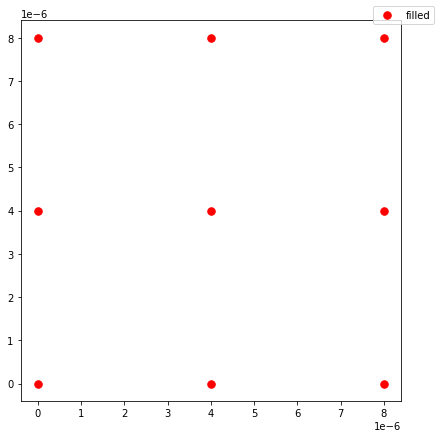

<Figure size 504x504 with 0 Axes>

In [4]:
# [Optional] We visually inspect the register

import matplotlib.pyplot as plt

def show_register(register):
    filled_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.FILLED]
    empty_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.VACANT]
    fig = plt.figure(figsize=(7, 7))
    plt.plot(np.array(filled_sites)[:, 0], np.array(filled_sites)[:, 1], 'r.', ms=15, label='filled')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.gca().set_aspect("equal")
    
show_register(register)
show_register(parallel_registers)

In [6]:
from utils import show_register as utils_show_register

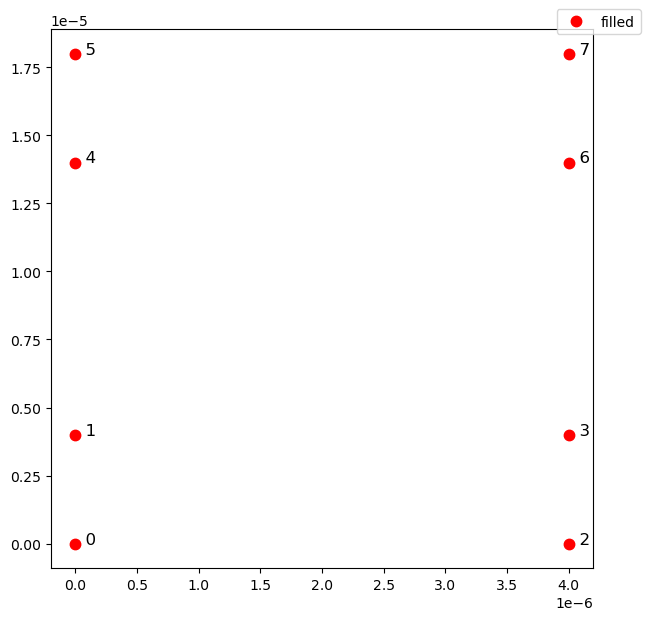

In [7]:
utils_show_register(parallel_registers)

In [8]:
from utils import get_drive

amplitude_min = 0
amplitude_max = 6.3e6  # rad / s
detuning_min = -6e6  # rad / s
detuning_max = 15e6  # rad / s
time_max = 4e-6  # s
time_ramp = 5e-7  # s
time_to_measure = 1e-7 # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

ahs_program = AnalogHamiltonianSimulation(
    register=parallel_registers, 
    hamiltonian=drive
)

In [9]:
task = qpu.run(ahs_program.discretize(qpu), shots=100)
print(task)

AttributeError: 'NoneType' object has no attribute 'run'

In [ ]:
# collecting all data

results = task.results()

all_measurements = []
for measurement in results.measurements:
    pass
    


## Local Simulator and Visualization

In [10]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

result = device.run(ahs_program, shots=1000).result()

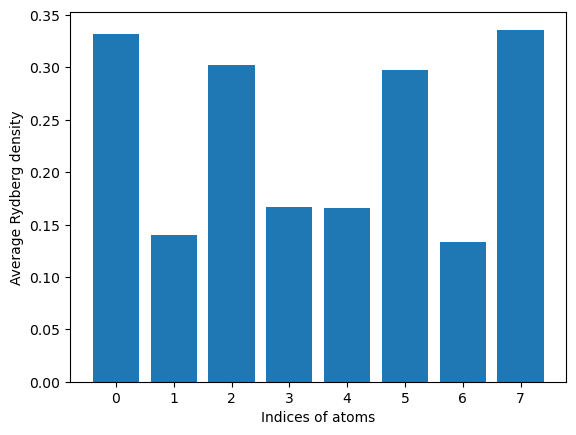

In [11]:
from utils import show_final_avg_density, get_avg_density
show_final_avg_density(result)

In [12]:
batch_mapping # coordinate supersystem
Lx, Ly # the sizes of the cells

(2, 2)

In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def plot_cell_density(result, batch_mapping, Lx, Ly):
    largest_x = max(batch_mapping.keys(), key = lambda k: k[0]) # gives tuple with the largest x value 
    largest_y = max(batch_mapping.keys(), key = lambda k: k[1]) # gives tuple with the largest y value
    
    num_subplot_sites = (largest_x[0] + 1, largest_y[1] + 1)
    fig, axs = plt.subplots(*num_subplot_sites)
    
    avg_density = get_avg_density(result)
    
    # iterate over each cell, with each cell getting its own subplot
    for cell, qubits in batch_mapping.items():


        # extract the associated average Rydberg density from each site,
        # then reshape from the original list so it's displayed properly
        avg_density_subgrid = []
        for qubit in qubits:
            avg_density_subgrid.append(avg_density[qubit])

        avg_density_subgrid = np.array(avg_density_subgrid).reshape(Lx,Ly)

        subgrid = np.rot90(np.array(qubits).reshape(Lx, Ly), k=1)

        # account for the fact that if you only have one row but multiple columns,
        # matplotlib just uses the column coordinate
        if num_subplot_sites[0] == 1:
            cell = cell[1]

        # do plotting inside subplot
        im = axs[cell].imshow(avg_density_subgrid, cmap="Blues")

        # add title 
        axs[cell].set_title(str(cell))

        # turn off axes
        axs[cell].axis("off")
        # overlay qubit numbers
        for (j,i),label in np.ndenumerate(subgrid):
            axs[cell].text(i,j,label, color='grey')

    # add a colorbar
    fig.colorbar(im, ax=axs.ravel().tolist())
        
    return fig, axs

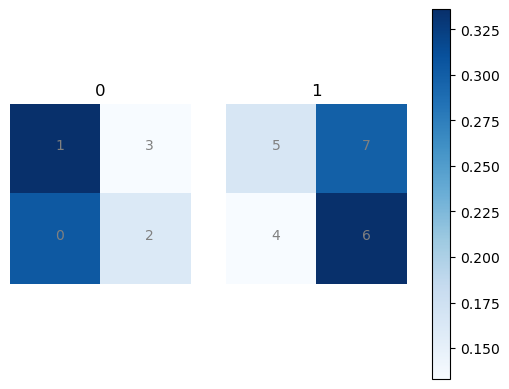

In [28]:
fig, axs = plot_cell_density(result=result,batch_mapping=batch_mapping, Lx=Lx, Ly=Ly)